[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Singer/surf_tense_mcmc.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Singer/surf_tens_mcmc.ipynb)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pylab
import numpy as np
from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics import constants_defaults as const
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer.aerosol import AerosolBetaCary

In [3]:
formulae_ovad = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants = {
        'sgm_org': 40.0 * si.mN / si.m,
        'delta_min': 0.3 * si.nm
    }
)
label = 'Ovad'

cases = {
    'Beta Caryophyllene': AerosolBetaCary()
}

T = 300 * si.K

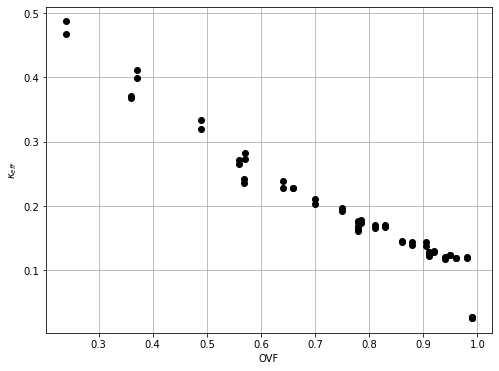

In [4]:
ds = np.loadtxt("bcary.csv",skiprows=1,delimiter=",")
r_dry = ds[:,0]*1e-9
ovf = np.minimum(ds[:,1], 0.99)
kappa_eff = ds[:,2]

datay = kappa_eff
errory = datay*0.1

args = [T, r_dry, ovf]

pylab.figure(figsize=(8,6))
pylab.plot(ovf, kappa_eff, 'ko')
pylab.xlabel("OVF")
pylab.ylabel("$\kappa_{eff}$")
pylab.rcParams.update({'font.size':15})
pylab.grid()
pylab.show()

[44.81707185  0.60653066]
[-0.04332005  0.55664212]
[35.22036103  1.74480382]


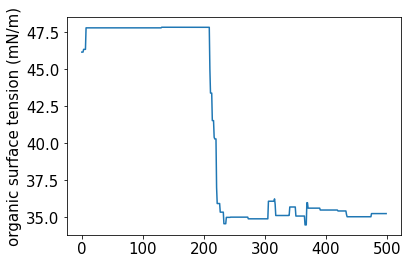

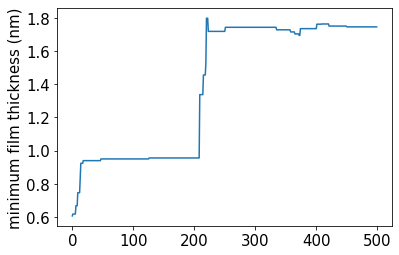

In [7]:
from importlib import reload
import kappa_mcmc
reload(kappa_mcmc)
from kappa_mcmc import param_transform, get_model, MCMC

#params = [0.22, -1.2]
params = [0.5, -0.5]
stepsize = [0.1,0.1]
print(param_transform(params))

n_steps = 500
param_chain, accept_chain, chi2_chain = MCMC(params, stepsize, args, datay, errory, n_steps)

p = param_transform(param_chain)
print(param_chain[:,-1])
print(p[:,-1])
pylab.plot(p[0,:])
pylab.ylabel("organic surface tension (mN/m)")
pylab.show()
pylab.plot(p[1,:])
pylab.ylabel("minimum film thickness (nm)")
pylab.show()

### Surface tension

[46.14184977  0.60653066]
[35.22036103  1.74480382]


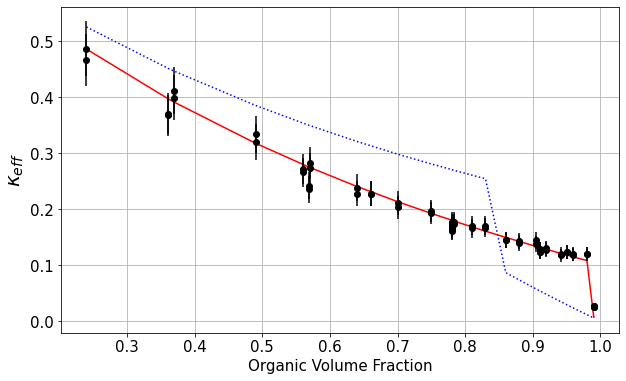

In [9]:
reload(kappa_mcmc)
from kappa_mcmc import param_transform, negSS
from scipy.optimize import minimize_scalar, minimize

dat = np.zeros((len(ovf),4))

c = AerosolBetaCary(ovf)
f_org = c.aerosol_modes_per_cc[0]['f_org']
kappa = c.aerosol_modes_per_cc[0]['kappa']['Ovad']

pylab.figure(figsize=(10,6))

# before
p = param_transform(param_chain[:,0])
print(p)

formulae_1 = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants = {
        'sgm_org': p[0] * si.mN / si.m,
        'delta_min': p[1] * si.nm
    }
)
Scrit, rcrit = np.zeros(len(r_dry)), np.zeros(len(r_dry))
for i, rd in enumerate(r_dry):
    a = [formulae_1, T, r_dry[i], kappa[i], f_org[i]]
    res = minimize_scalar(negSS, args=a)
    Scrit[i], rcrit[i] = -1*res.fun, res.x

kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w
s = np.argsort(ovf)
dat[:,0] = ovf[s]
dat[:,2] = kap_eff[s]
pylab.plot(ovf[s], kap_eff[s], 'b:', label="before")

# after
p = param_transform(param_chain[:,-1])
print(p)

formulae_2 = Formulae(
    surface_tension='CompressedFilmOvadnevaite',
    constants = {
        'sgm_org': p[0] * si.mN / si.m,
        'delta_min': p[1] * si.nm
    }
)
Scrit, rcrit = np.zeros(len(r_dry)), np.zeros(len(r_dry))
for i, rd in enumerate(r_dry):
    a = [formulae_2, T, r_dry[i], kappa[i], f_org[i]]
    res = minimize_scalar(negSS, args=a)
    Scrit[i], rcrit[i] = -1*res.fun, res.x

kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w
s = np.argsort(ovf)
dat[:,3] = kap_eff[s]
pylab.plot(ovf[s], kap_eff[s], 'r-', label="after")

# data
s = np.argsort(ovf)
dat[:,1] = kappa_eff[s]
pylab.errorbar(ovf, kappa_eff, yerr=errory, fmt='ko')

#pylab.colorbar(label="Dry radius (nm)")
pylab.xlabel("Organic Volume Fraction")
pylab.ylabel("$\kappa_{eff}$",fontsize=20)
pylab.rcParams.update({"font.size":15})
pylab.grid()
pylab.show()

# print(dat)
# np.savetxt("Ryan_mcmc.csv", dat, delimiter=',', fmt='%.4f', 
#            header='OVF, Kappa meas, Kappa before, Kappa after', 
#            comments='before: 44.82, 0.61 // after: 34.77, 1.73\n')